In [41]:
"""
MIT License

Copyright (c) 2021 Ian Housman

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""
#Notebook to summarize modeled depth to groundwater values across various geographic areas
##################################################
import os
import pandas as pd
import os,glob,datetime
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import mapply
##################################################
#Set up params
#Directory containing exported modeled DGW tables
table_dir = r'C:\TNC\manuscript_2020\iGDE_Monitor_Outputs\pred_tables'

#Directory for output pickles and csv tables to go
summary_table_dir = r'C:\TNC\manuscript_2020\iGDE_Monitor_Outputs\pickles'

#Specify fields to keep from modeled tables
use_colummns = ['year','POLYGON_ID','matchesN','matchesReduced','modeled_DGW','Hydroregion_Number','Groundwater_Basin_ID']


#Make dir if it doesn't exist
if not os.path.exists(summary_table_dir):os.makedirs(summary_table_dir)   

print('done')

done


In [42]:
#Read in tables
#Will only read in csvs if pickle version doesn't exist
tables = glob.glob(os.path.join(table_dir,'*.csv'))
full_pickle = os.path.join(summary_table_dir,'All_Tables.pckl')
if not os.path.exists(full_pickle):
    li = []
    for filename in tables:
        print('Reading in: ',filename)
        df = pd.read_csv(filename, index_col=None, header=0,skipinitialspace=True, usecols=use_colummns)
        li.append(df)
    df = pd.concat(li, axis=0, ignore_index=True)
    df.to_pickle(full_pickle)
else:
    print('Reading in:',full_pickle)
    df = pd.read_pickle(full_pickle)
print(df.shape)

Reading in: C:\TNC\manuscript_2020\iGDE_Monitor_Outputs\pickles\All_Tables.pckl
(3329526, 7)


In [43]:
#Specify which columns to keep and the final output column names
keep_columns = ['POLYGON_ID','matchesN','matchesReduced','Hydroregion_Number','Groundwater_Basin_ID']
column_names = ['POLYGON_ID','matchesN','matchesReduced','Hydroregion_Number','Groundwater_Basin_ID','N','StartYear','EndYear','Years','Preds','OLS_Intercept','OLS_Slope','OLS_Pvalue','OLS_SigDir']

print(column_names)
print(keep_columns)

['POLYGON_ID', 'matchesN', 'matchesReduced', 'Hydroregion_Number', 'Groundwater_Basin_ID', 'N', 'StartYear', 'EndYear', 'Years', 'Preds', 'OLS_Intercept', 'OLS_Slope', 'OLS_Pvalue', 'OLS_SigDir']
['POLYGON_ID', 'matchesN', 'matchesReduced', 'Hydroregion_Number', 'Groundwater_Basin_ID']


In [48]:
#Run ols regression
#Function to run ols for a specified POLYGON_ID for a set of years
def apply_ols(id,df,startYear,endYear,alpha = 0.05):
    
    #Set up the years
    years = np.arange(startYear,endYear+1)

    #Filter out rows for the id and years
    dft = df[df.POLYGON_ID == id]
    dft = dft[dft.year.isin(years)]
    
    #Pull other columns (should be the same for a given POLYGON_ID)
    keep = dft[keep_columns].values[0]
    
    #Pull in variables for OLS and fit model
    y = dft['modeled_DGW'].values*-1 # response
    years = dft['year'].values
    X = years  # predictor
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    res = sm.OLS(y,X)
    
    #Pull out results
    intercept = res.fit().params[0]
    slope = res.fit().params[1]
    pvalue = res.fit().pvalues[1]
    
    #Threshold p value
    olsSig = pvalue <= alpha
    if not olsSig:
        sigDir =  'no trend'
    elif olsSig and slope < 0:
        sigDir = 'decreasing'
    elif olsSig and slope > 0:
        sigDir =  'increasing'
    elif olsSig and slope == 0:
        sigDir =  'flat'
   
    out_line = list(keep)
    out_line.extend([len(y),startYear,endYear,years,y,intercept,slope,pvalue,sigDir])

   
    return out_line
  
############################################################
#Function call
year_sets =[[1985,2019],[1985,2002],[2003,2019]]

print(df.shape)
for startYear,endYear in year_sets:
    out_pickle = os.path.join(summary_table_dir,'DGW_Trends_{}-{}.pckl'.format(startYear,endYear))
    if not os.path.exists(out_pickle):
        print('processing',startYear,endYear)
        ids = np.unique(df.POLYGON_ID)[:20]
        total = len(ids)
        out = []
        for i,id in enumerate(ids):

            try:
                out_line = apply_ols(id,df,startYear, endYear)
                out.append(out_line)
            except Exception as e:
                print(e)

        out = pd.DataFrame(out, columns = column_names)
        display(out.head(3))

        print(out_pickle)
        out.to_pickle(out_pickle)
    else:
        print('Already created: ',out_pickle)
    

(3329526, 7)
Already created:  C:\TNC\manuscript_2020\iGDE_Monitor_Outputs\pickles\DGW_Trends_1985-2019.pckl
Already created:  C:\TNC\manuscript_2020\iGDE_Monitor_Outputs\pickles\DGW_Trends_1985-2002.pckl
Already created:  C:\TNC\manuscript_2020\iGDE_Monitor_Outputs\pickles\DGW_Trends_2003-2019.pckl


1985 2019
1985 2002
2003 2019


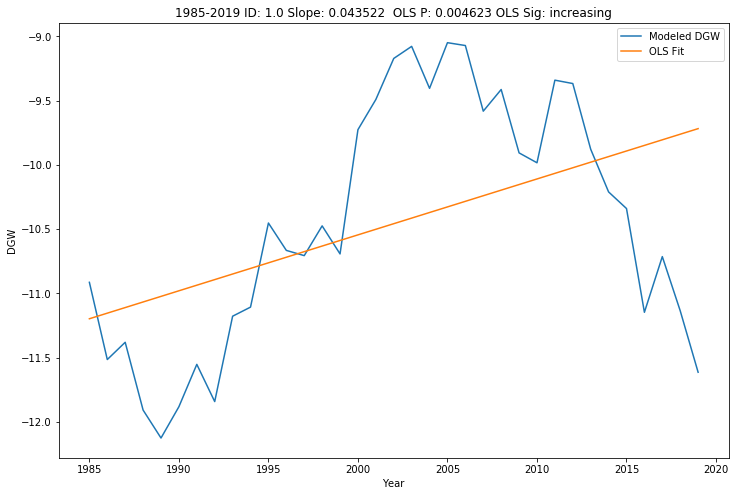

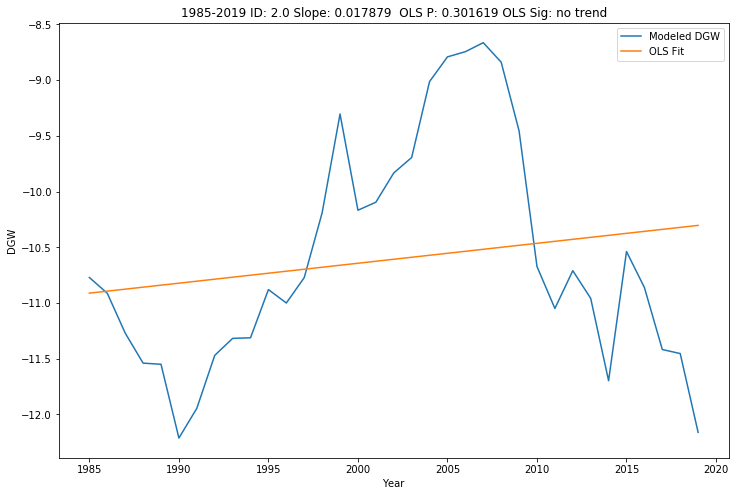

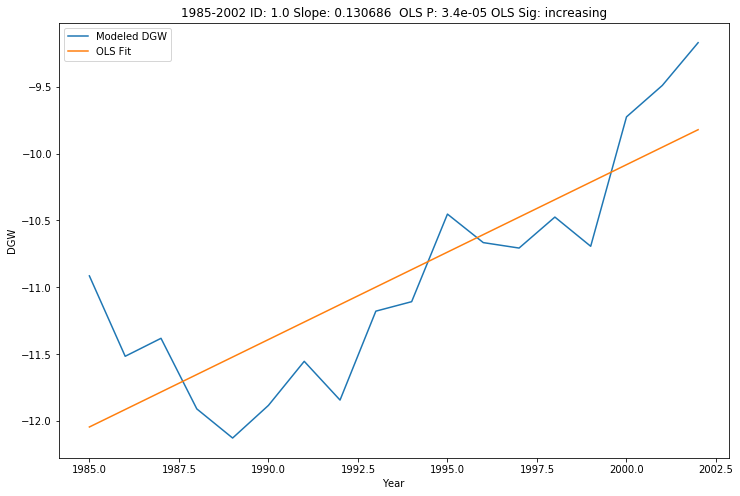

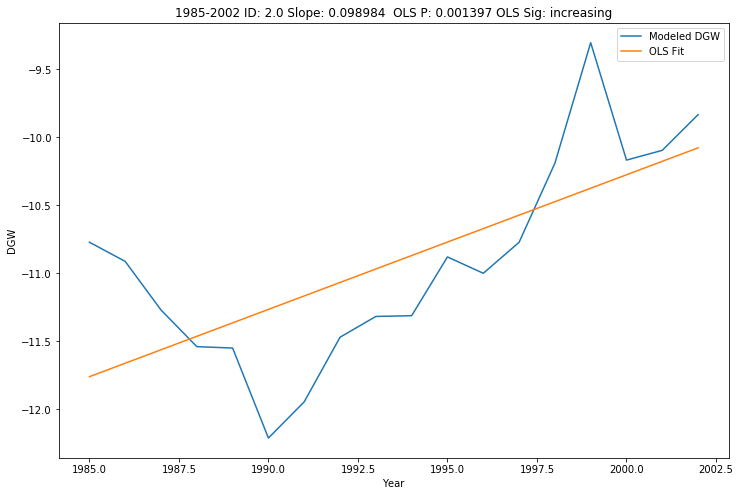

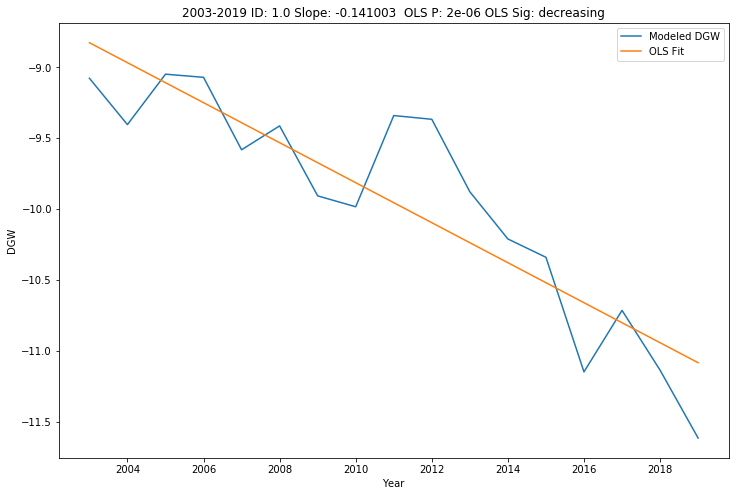

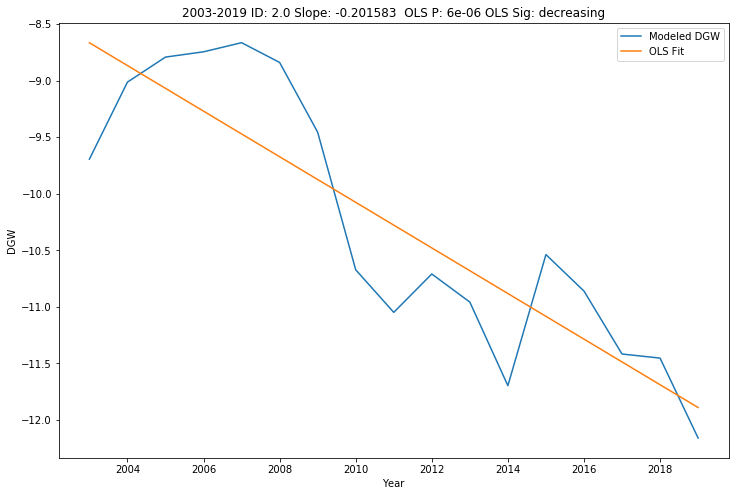

In [50]:
#Plot some results
def plot_fit(row,startYear,endYear):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    id = row['POLYGON_ID']
    xs = row['Years']
    ys = row['Preds']
    predicted = xs*row['OLS_Slope']+row['OLS_Intercept']
   
    plt.title('{}-{} ID: {} Slope: {}  OLS P: {} OLS Sig: {}'.format(startYear,endYear,id,round(row['OLS_Slope'],6),round(row['OLS_Pvalue'],6),row['OLS_SigDir']))
    ax.plot(xs,ys)
    ax.plot(xs, predicted)

    ax.legend(['Modeled DGW', 'OLS Fit'])
    ax.set_xlabel('Year')
    ax.set_ylabel('DGW')

#Plot the first 2 igdes for each year set
if __name__ == '__main__':
    for startYear,endYear in year_sets:
        print(startYear,endYear)
        out_pickle = os.path.join(summary_table_dir,'DGW_Trends_{}-{}.pckl'.format(startYear,endYear))
        out = pd.read_pickle(out_pickle)
        out.head(2).apply(plot_fit, args = (startYear,endYear), axis=1)
   

In [40]:
#Group summarize trend results
group_fields = ['statewide','Hydroregion_Number','Groundwater_Basin_ID']
pd.options.display.float_format = '{:.4}'.format
for group_field in group_fields:
    summary_counts_table = []
    i = 0
    out_columns = []
    for startYear,endYear in year_sets:
        out_pickle = os.path.join(summary_table_dir,'DGW_Trends_{}-{}.pckl'.format(startYear,endYear))
        out = pd.read_pickle(out_pickle)
        out['statewide'] = 1
        print(out.shape)
        df = out
        if i == 0:
            med_slope =out.groupby([group_field])['OLS_Slope'].agg(['count','median'])
        else:
            med_slope =out.groupby([group_field])['OLS_Slope'].agg(['median'])

        counts = out.groupby([group_field])['OLS_SigDir'].value_counts(normalize=True)

        t = pd.concat([med_slope,counts.unstack()],axis = 1)
        columnsT = ['OLS_Median_Trend_{}_{}'.format(startYear,endYear),'OLS_Decreasing_Trend_Sig_{}_{}'.format(startYear,endYear),'OLS_Increasing_Trend_Sig_{}_{}'.format(startYear,endYear),'OLS_No_Trend_Sig_{}_{}'.format(startYear,endYear)]
        if i == 0:
            columns = ['count']
            columns.extend(columnsT)
        else:
            columns = columnsT
        t.columns = columns
        summary_counts_table.append(t)
        i+=1

    summary_counts_table = pd.concat(summary_counts_table, axis=1)
    display(summary_counts_table)
    out_csv =  os.path.join(summary_table_dir,group_field + '_Summary.csv')
    summary_counts_table.to_csv(out_csv)


(95135, 15)
(95135, 15)
(95131, 15)


,count,OLS_Median_Trend_1985_2019,OLS_Decreasing_Trend_Sig_1985_2019,OLS_Increasing_Trend_Sig_1985_2019,OLS_No_Trend_Sig_1985_2019,OLS_Median_Trend_1985_2002,OLS_Decreasing_Trend_Sig_1985_2002,OLS_Increasing_Trend_Sig_1985_2002,OLS_No_Trend_Sig_1985_2002,OLS_Median_Trend_2003_2019,OLS_Decreasing_Trend_Sig_2003_2019,OLS_Increasing_Trend_Sig_2003_2019,OLS_No_Trend_Sig_2003_2019
statewide,,,,,,,,,,,,,
1,95135,-0.007049,0.4045,0.2903,0.3053,0.004722,0.2543,0.3003,0.4455,-0.01243,0.376,0.256,0.368


(95135, 15)
(95135, 15)
(95131, 15)


,count,OLS_Median_Trend_1985_2019,OLS_Decreasing_Trend_Sig_1985_2019,OLS_Increasing_Trend_Sig_1985_2019,OLS_No_Trend_Sig_1985_2019,OLS_Median_Trend_1985_2002,OLS_Decreasing_Trend_Sig_1985_2002,OLS_Increasing_Trend_Sig_1985_2002,OLS_No_Trend_Sig_1985_2002,OLS_Median_Trend_2003_2019,OLS_Decreasing_Trend_Sig_2003_2019,OLS_Increasing_Trend_Sig_2003_2019,OLS_No_Trend_Sig_2003_2019
Hydroregion_Number,,,,,,,,,,,,,
13.0,10348,-0.01742,0.5047,0.1971,0.2981,-0.0163,0.3324,0.1881,0.4795,0.009461,0.2575,0.3374,0.4051
14.0,14353,0.01012,0.2319,0.4632,0.3048,-0.006384,0.2705,0.1972,0.5322,0.02381,0.189,0.4929,0.3182
15.0,2327,0.01572,0.1921,0.5019,0.306,0.01669,0.2235,0.4083,0.3683,0.008727,0.251,0.3661,0.3829
16.0,1254,-0.0269,0.5933,0.1356,0.2711,-0.0366,0.4864,0.1794,0.3341,-0.007743,0.3469,0.2711,0.382
17.0,22271,-0.02734,0.5546,0.1713,0.274,-0.001698,0.3059,0.2561,0.438,-0.03476,0.4423,0.1629,0.3949
18.0,6392,-0.002332,0.3439,0.2979,0.3583,0.02837,0.1422,0.4723,0.3855,-0.02798,0.4363,0.1888,0.3749
19.0,15908,-0.009318,0.3882,0.2992,0.3126,0.04626,0.1368,0.4745,0.3886,-0.05847,0.5707,0.1311,0.2982
21.0,5740,0.00842,0.274,0.4115,0.3145,0.03112,0.1528,0.4286,0.4186,-0.004552,0.3056,0.2596,0.4348
22.0,11276,-0.007939,0.4164,0.2457,0.338,-0.01216,0.3286,0.2176,0.4538,-0.01557,0.3989,0.2114,0.3897


(95135, 15)
(95135, 15)
(95131, 15)


,count,OLS_Median_Trend_1985_2019,OLS_Decreasing_Trend_Sig_1985_2019,OLS_Increasing_Trend_Sig_1985_2019,OLS_No_Trend_Sig_1985_2019,OLS_Median_Trend_1985_2002,OLS_Decreasing_Trend_Sig_1985_2002,OLS_Increasing_Trend_Sig_1985_2002,OLS_No_Trend_Sig_1985_2002,OLS_Median_Trend_2003_2019,OLS_Decreasing_Trend_Sig_2003_2019,OLS_Increasing_Trend_Sig_2003_2019,OLS_No_Trend_Sig_2003_2019
Groundwater_Basin_ID,,,,,,,,,,,,,
1.0,9,0.06225,nan,1.0,nan,0.1148,nan,1.0,nan,-0.02799,0.4444,0.2222,0.3333
2.0,17,-0.0126,0.3529,nan,0.6471,-0.003243,0.1176,0.1176,0.7647,-0.08401,1.0,nan,nan
3.0,6,0.04863,nan,0.6667,0.3333,0.1458,nan,1.0,nan,-0.03439,0.6667,0.1667,0.1667
5.0,49,0.02698,0.04082,0.5714,0.3878,0.1184,nan,0.8367,0.1633,-0.04036,0.5918,0.102,0.3061
7.0,12,-0.01522,0.5833,nan,0.4167,-0.03842,0.5,nan,0.5,0.0367,nan,0.75,0.25
8.0,53,-0.00748,0.4717,0.2453,0.283,-0.0175,0.1698,0.03774,0.7925,0.01761,0.09434,0.5283,0.3774
9.0,8,-0.01153,0.375,nan,0.625,0.02917,0.125,0.375,0.5,-0.03364,0.5,0.125,0.375
10.0,11,0.03239,0.1818,0.5455,0.2727,0.1262,nan,1.0,nan,-0.02928,0.3636,0.09091,0.5455
11.0,37,0.0009041,0.1351,0.1081,0.7568,0.04956,0.08108,0.7568,0.1622,-0.008721,0.3243,0.2162,0.4595


# <html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>

